In [19]:
%load_ext autoreload
%autoreload 2
%load_ext line_profiler

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from numba import njit

In [66]:
from fsd_path_planning.demo.json_demo import load_data_json
from pathlib import Path


# data = list(zip(*load_data_json(Path('fsd_path_planning/demo/october_gatow_3.json'), remove_color_info=True)))
data = list(zip(*load_data_json(Path('fsd_path_planning/demo/fss_19_4_laps.json'), remove_color_info=False)))
# data = list(zip(*load_data_json(Path('fsd_path_planning/demo/layout_6_4_laps.json'), remove_color_info=False)))
# data = list(zip(*load_data_json(remove_color_info=True)))
print(len(data))

1381


In [53]:
from fsd_path_planning import MissionTypes, PathPlanner
from fsd_path_planning.sorting_cones.trace_sorter.core_trace_sorter import TraceSorter



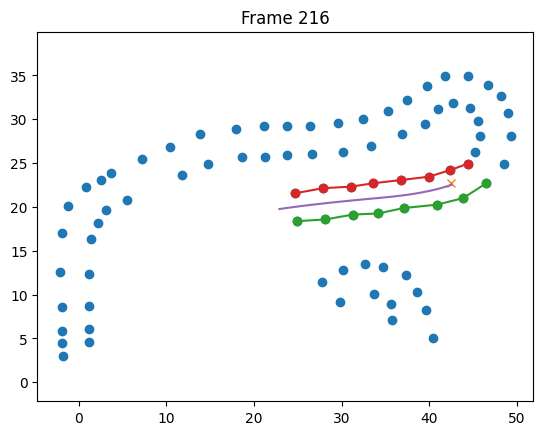

In [69]:

frame = 1243
frame = 181

# TOOD: october_gatow_3.json frame 490
# ΤΟDO: october_gatow.json frame 330

start_frame = 216
end_frame = 0

if end_frame <= start_frame:
    end_frame = start_frame + 1

for i in range(start_frame, end_frame):

    planner = PathPlanner(MissionTypes.trackdrive)

    car_position, car_direction, cones = data[i]

    out = planner.calculate_path_in_global_frame(
        cones,
        car_position,
        car_direction,
        return_intermediate_results=True,
    )

    # %timeit planner.calculate_path_in_global_frame(cones,car_position,car_direction,return_intermediate_results=True)
    # assert isinstance(out, tuple)

    (
        final_path,
        sorted_left,
        sorted_right,
        left_cones_with_virtual,
        right_cones_with_virtual,
        left_to_right_match,
        right_to_left_match,
    ) = out

    all_cones = np.row_stack(cones)

    plt.plot(all_cones[:, 0], all_cones[:, 1], 'o')
    plt.plot(car_position[0], car_position[1], 'x')
    plt.plot(*sorted_left.T, 'o-')
    plt.plot(*sorted_right.T, 'o-')
    # plt.plot(*left_cones_with_virtual.T, 'o-')
    # plt.plot(*right_cones_with_virtual.T, 'o-')
    plt.plot(*final_path[:,1:3].T, '-')
    plt.axis('equal')
    plt.title(f'Frame {i}')
    plt.show()



{'max_n_neighbors': 5, 'max_dist': 6.5, 'max_dist_to_first': 6.0, 'max_length': 11, 'threshold_directional_angle': 0.6981317007977318, 'threshold_absolute_angle': 1.1344640137963142, 'use_unknown_cones': True}


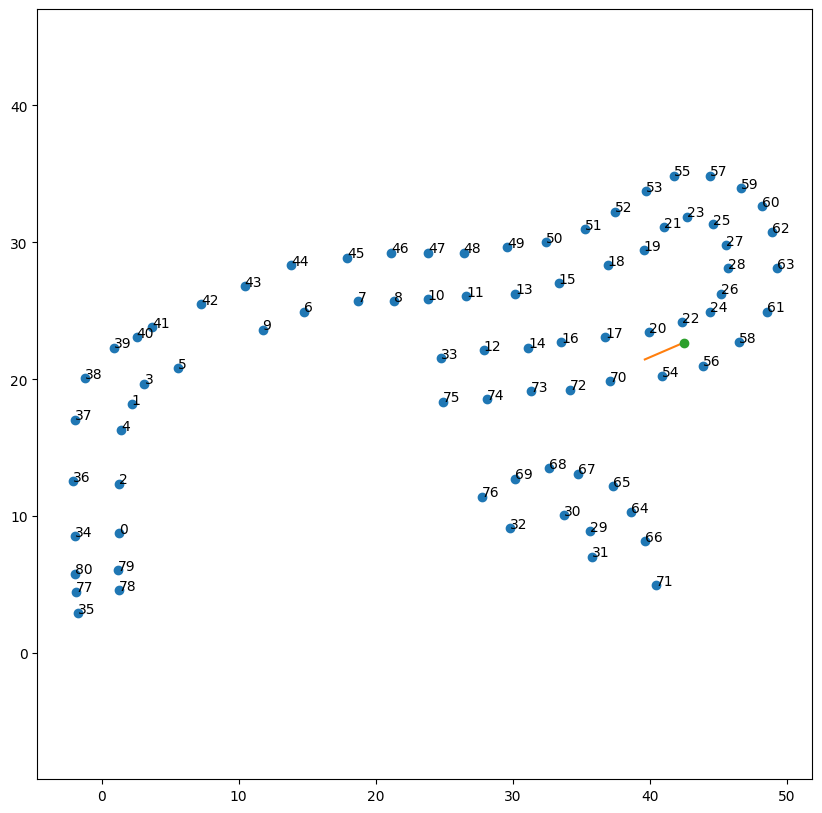

8 8


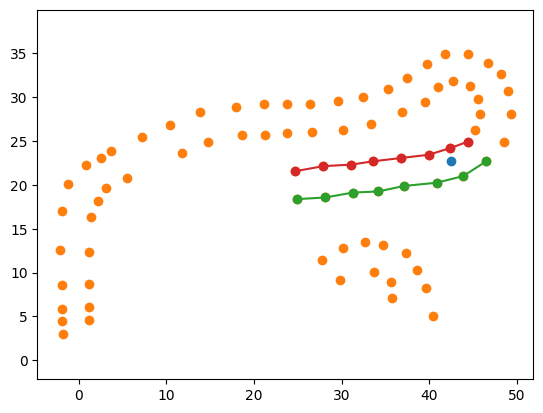

In [70]:
from fsd_path_planning.config import get_cone_sorting_config
from fsd_path_planning import ConeTypes

c = get_cone_sorting_config(MissionTypes.trackdrive)
print(c)
c1 = c.copy()
del c1['use_unknown_cones']

ts = TraceSorter(**c1)

cones_flat = ts.flatten_cones_by_type_array(cones)

mask_keep = np.ones(len(cones_flat), dtype=bool)
# mask_keep[17] = False

cones_flat = cones_flat[mask_keep]
plt.figure(figsize=(10,10))
plt.plot(cones_flat[:, 0], cones_flat[:, 1], "o")

car_end = car_position + car_direction * 3.1
car_s = np.array([car_position, car_end])
plt.plot(*car_s.T, "-")
plt.plot(*car_position, "o")
for i, cone in enumerate(cones_flat):
    plt.text(cone[0], cone[1], str(i))

plt.axis("equal")
plt.show()

# start_idx = ts.select_first_k_starting_cones(car_position, car_direction, cones_flat, ConeTypes.RIGHT)
plt.plot(car_position[0], car_position[1], "o")
l,r = ts.sort_left_right(cones, car_position, car_direction)
# %timeit ts.sort_left_right(cones, car_position, car_direction)
plt.plot(cones_flat[:, 0], cones_flat[:, 1], "o")
# plt.plot(cones_flat[start_idx, 0], cones_flat[start_idx, 1], "o-")
# plt.plot(car_position[0], car_position[1], "o")
plt.plot(*l.T, "o-")
plt.plot(*r.T, "o-")
plt.axis("equal")

print(len(l), len(r))



(12.691934685513376, 31.19554474421913, -12.53685680263475, 0.59656157532975)

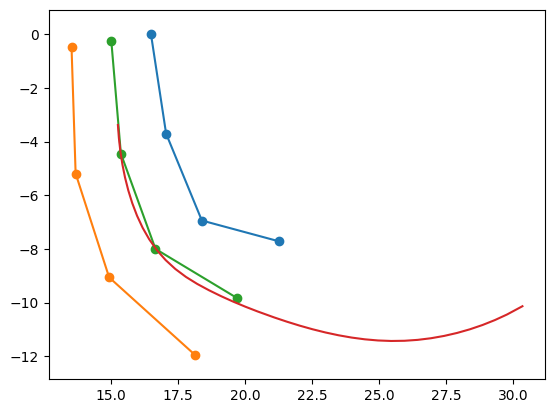

In [65]:
from fsd_path_planning.calculate_path.core_calculate_path import PathCalculationInput
from fsd_path_planning.utils.math_utils import my_cdist_sq_euclidean
from fsd_path_planning.config import create_default_pathing
from numpy import array, int32

path_input = PathCalculationInput(left_cones=array([[ 1.64988708e+01, -4.11987305e-04],
       [ 1.70621085e+01, -3.70204451e+00],
       [ 1.83951273e+01, -6.94163639e+00],
       [ 2.12796364e+01, -7.71970364e+00]]), right_cones=array([[ 13.53300787,  -0.45169546],
       [ 13.68637085,  -5.18791199],
       [ 14.93637085,  -9.06291199],
       [ 18.12240577, -11.93988324]]), left_to_right_matches=array([0, 1, 2, 3]), right_to_left_matches=array([0, 1, 2, 2]), position_global=array([14.61155701, -3.39581299]), direction_global=array([ 0.17436977, -0.98468024]))


my_cdist_sq_euclidean(path_input.left_cones, path_input.right_cones)

pathing = create_default_pathing(MissionTypes.trackdrive)

pathing.input = path_input

path_param, centerline = pathing.run_path_calculation()

plt.plot(*path_input.left_cones.T, "o-")
plt.plot(*path_input.right_cones.T, "o-")
plt.plot(*centerline.T, "o-")
plt.plot(*path_param[:, 1:3].T, "-")
plt.axis("equal")

In [43]:
from fsd_path_planning.sorting_cones.trace_sorter.find_configs_and_scores import calc_scores_and_end_configurations
from fsd_path_planning.sorting_cones.trace_sorter.adjacency_matrix import create_adjacency_matrix
import fsd_path_planning.sorting_cones.trace_sorter.adjacency_matrix as am

# am.LAST_MATRIX_CALC_HASH = None
# am.LAST_IDXS_HASH = None


# %lprun -u 1e-3 -f ts.sort_left_right -f calc_scores_and_end_configurations -f create_adjacency_matrix ts.sort_left_right(cones, car_position, car_direction)

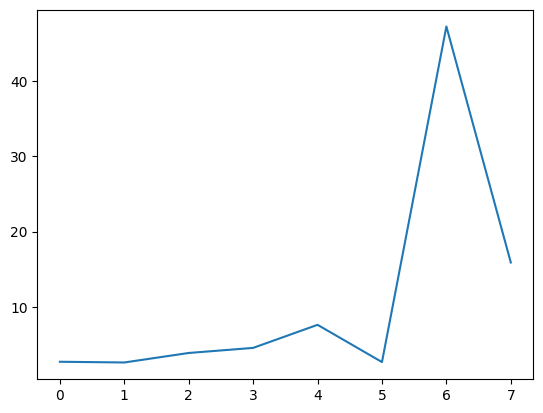

In [79]:
from fsd_path_planning.utils.math_utils import center_of_circle_from_3_points

idxs = [21,23,25,27,28,26,24,22,20,17]

r = []

for i in range(1, len(idxs)-1):
    points = cones_flat[idxs[i-1:i+2],:2]
    c = center_of_circle_from_3_points(*points)
    r.append(np.linalg.norm(points - c, axis=1).mean())


plt.plot(r)
# points = cones_flat[42:45,:2]

# c = center_of_circle_from_3_points(*points)

# np.linalg.norm(points - c, axis=1)

In [21]:
a = np.random.rand(200,2)
%timeit hash(a.tobytes())
%timeit hash(a.data.tobytes())

2.9 µs ± 437 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)
2.87 µs ± 250 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


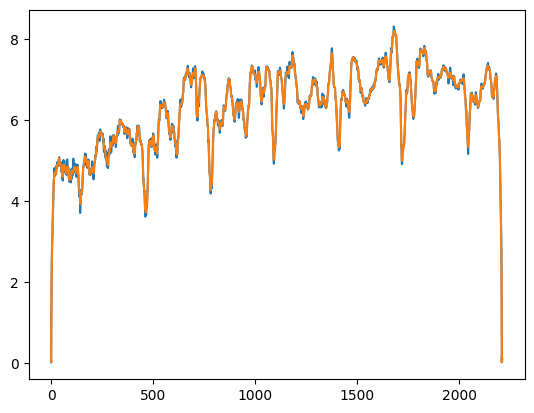

In [68]:
from scipy.ndimage import median_filter

positions = np.array([a[0] for a in data])

diff = (positions[2:] - positions[:-2]) / 0.2
n = np.linalg.norm(diff, axis=1)


n_filtered = median_filter(n, size=5)

d = np.cumsum(n_filtered) * 0.2
# d = np.concatenate([[0], d])
plt.plot(d,n)
plt.plot(d,n_filtered)

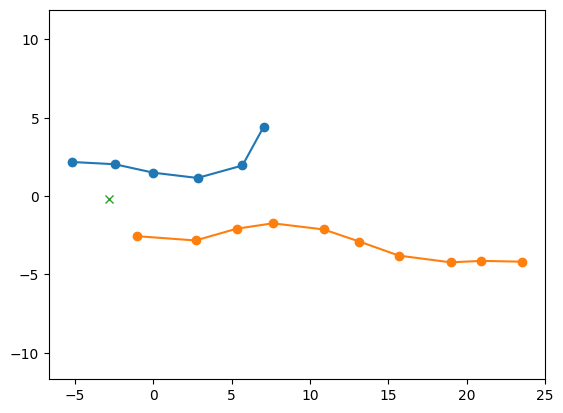

[162.39337788 159.85533929 146.60709999  17.21796608  73.44447264
 168.1786246  179.06984014 167.75073208 169.8496284  176.05388395]
[170.63475762 174.42162984 157.69813051 134.28991921  79.55634966
 159.05580359 178.11790717 167.09045612 169.45082785 175.54114617]


(-6.815897139917956, 25.073274581101092, -4.55044183, 2.4951866500000004)

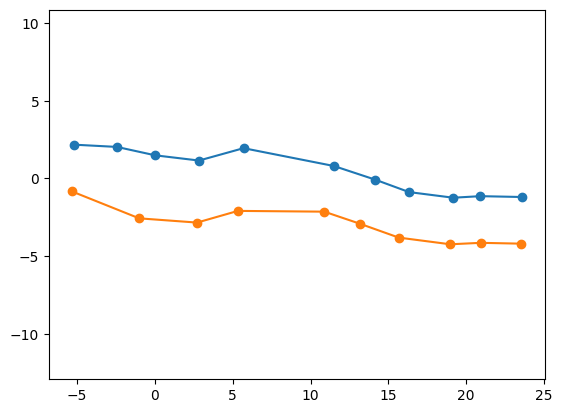

In [51]:
from fsd_path_planning.config import create_default_cone_matching_with_non_monotonic_matches
from fsd_path_planning.cone_matching.core_cone_matching import ConeMatchingState
from numpy import array

m = create_default_cone_matching_with_non_monotonic_matches(4)

state = ConeMatchingState(min_track_width=3, max_search_range=5, max_search_angle=0.8726646259971648, matches_should_be_monotonic=False, sorted_left=array([[-5.20930004,  2.17493081],
       [-2.44987106,  2.03024006],
       [ 0.0198734 ,  1.48873162],
       [ 2.8299098 ,  1.15423059],
       [ 5.69535446,  1.94961262],
       [ 7.0578537 ,  4.43040133]]), sorted_right=array([[-1.01604104, -2.56143904],
       [ 2.70356989, -2.83450651],
       [ 5.33292341, -2.0832355 ],
       [ 7.63778877, -1.7402972 ],
       [10.88364601, -2.13238001],
       [13.16276741, -2.90422082],
       [15.67347813, -3.80018067],
       [18.98889732, -4.23018599],
       [20.94279289, -4.13597679],
       [23.56168938, -4.19017982]]))


state.position_global = array([-2.79935072, -0.16019239])
state.direction_global = array([ 0.99666242, -0.08163346])
m.state = state

plt.plot(*state.sorted_left.T, 'o-')
plt.plot(*state.sorted_right.T, 'o-')
plt.plot(state.position_global[0], state.position_global[1], 'x')
plt.axis('equal')
plt.show()


out = m.run_cone_matching()
left_w_virtual, right_w_virtual, left_to_right_match, right_to_left_match = out
left_w_virtual
plt.plot(*left_w_virtual.T, 'o-')
plt.plot(*right_w_virtual.T, 'o-')
plt.axis('equal')

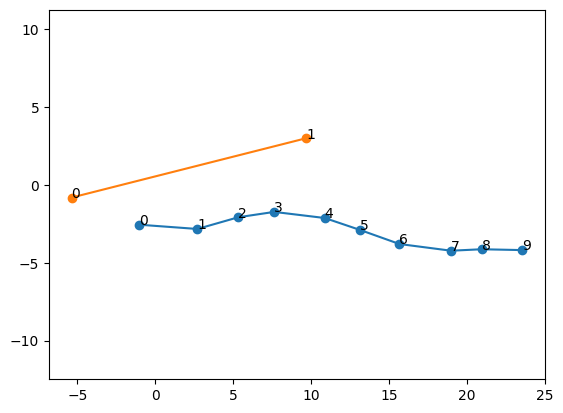

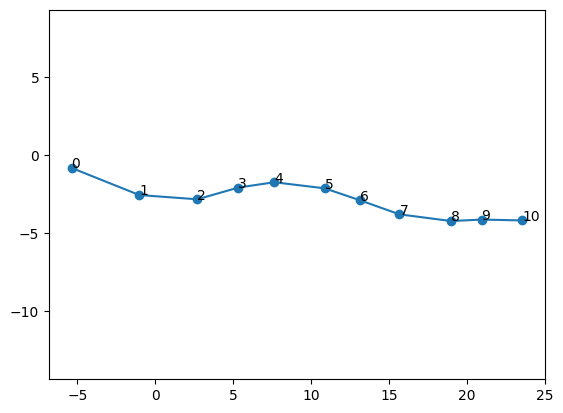

In [44]:
from fsd_path_planning.cone_matching.functional_cone_matching import insert_virtual_cones_to_existing

kwargs = {'other_side_cones': array([[-1.01604104, -2.56143904],
       [ 2.70356989, -2.83450651],
       [ 5.33292341, -2.0832355 ],
       [ 7.63778877, -1.7402972 ],
       [10.88364601, -2.13238001],
       [13.16276741, -2.90422082],
       [15.67347813, -3.80018067],
       [18.98889732, -4.23018599],
       [20.94279289, -4.13597679],
       [23.56168938, -4.19017982]]), 'other_side_virtual_cones': array([[-5.36638933, -0.82095353],
       [ 9.68736682,  2.98621964]]), 'car_position': array([-2.79935072, -0.16019239])}

osc = kwargs['other_side_cones']

plt.plot(*osc.T, 'o-')
for i in range(len(osc)):
    plt.annotate(i, osc[i])

osvc = kwargs['other_side_virtual_cones']
plt.plot(*osvc.T, 'o-')
for i in range(len(osvc)):
       plt.annotate(i, osvc[i])


plt.axis('equal')
plt.show()
out, _= insert_virtual_cones_to_existing(**kwargs)

plt.plot(*out.T, 'o-')
for i in range(len(out)):
    plt.annotate(i, out[i])
plt.axis('equal')
plt.show()

In [8]:
from fsd_path_planning.sorting_cones.trace_sorter.combine_traces import calc_final_configs_when_both_available
from fsd_path_planning.sorting_cones.trace_sorter.cost_function import cost_configurations

# %lprun -f cost_configurations -f ts.sort_left_right ts.sort_left_right(cones, car_position, car_direction) 

In [10]:
from fsd_path_planning.sorting_cones.trace_sorter.nearby_cone_search import number_cones_on_each_side_for_each_config
from numpy import array, int32

configs = array([[148,  69,  71,  62,  50,  49,  52,  53,  59,  66, 172],
       [148,  69,  71,  62,  50,  49,  52,  53,  59,  66, 113],
       [148,  69,  71,  62,  57,  56, 110,  61,  66,  -1,  -1],
       [148,  69,  71,  62,  57,  56, 110,  59,  -1,  -1,  -1],
       [148,  69,  71,  62,  57,  56, 110,  61, 112, 113, 172],
       [148,  69,  71,  62,  57,  56, 110,  61, 112, 109, 114],
       [148,  69,  71,  62,  57,  56, 110,  61, 112, 109, 104]],
      dtype=int32)


# a,b = number_cones_on_each_side_for_each_config(cones_flat, configs, ConeTypes.LEFT,  6.0, np.pi / 2,)
# a_alt, b_alt = number_cones_on_each_side_for_each_config_alt(cones_flat, configs, ConeTypes.LEFT,  6.0, np.pi / 2,)

# # %timeit number_cones_on_each_side_for_each_config(cones_flat, configs, ConeTypes.LEFT,  6.0, np.pi / 2,)
# # %timeit number_cones_on_each_side_for_each_config_alt(cones_flat, configs, ConeTypes.LEFT,  6.0, np.pi / 2,)

# np.testing.assert_array_equal(a, a_alt)
# np.testing.assert_array_equal(b, b_alt)

In [ ]:
# number_cones_on_each_side_for_each_config, number_cones_on_each_side_for_each_config_alt

(-3.296504478706724, 3.285609099981643, -3.291258042540579, 3.2936209478009713)

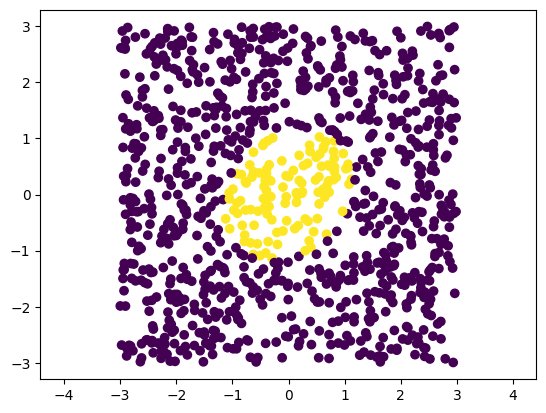

In [29]:
r = (np.random.rand(1000, 2) * 2 - 1) * 3

from fsd_path_planning.utils.math_utils import points_inside_ellipse

# f = njit(points_inside_ellipse)

center = np.array([0,0])
direction = np.array([1,1])
major_radius = 1.3
minor_radius = 1

# %timeit m = f(r, center, direction, major_radius, minor_radius)
# %timeit m = points_inside_ellipse(r, center, direction, major_radius, minor_radius)

m1 = f(r, center, direction, major_radius, minor_radius)
m2 = points_inside_ellipse(r, center, direction, major_radius, minor_radius)

np.testing.assert_array_equal(m1, m2)



plt.scatter(*r.T, c=m1)
plt.axis("equal")

In [ ]:
from fsd_path_planning.sorting_cones.trace_sorter.nearby_cone_search import create_angle_cache, create_seach_directions_cache, my_cdist_sq_euclidean

class NearbyConeSearcher:

    def __init__(self) -> None:
        self.caches_cache: dict[tuple[bytes, ConeTypes], tuple[dict, dict, np.ndarray, np.ndarray]] = {}

    def get_caches(self, cones: np.ndarray, cone_type: ConeTypes) -> tuple[dict, dict]:
        array_buffer = cones.tobytes()
        cache_key = (array_buffer, cone_type)
        if cache_key not in self.caches_cache:
            cones_xy = cones[:, :2]
            distance_matrix_square = my_cdist_sq_euclidean(cones_xy, cones_xy)
            np.fill_diagonal(distance_matrix_square, 1e7)
            cones_to_cones = cones_xy - cones_xy[:, None]

            self.caches_cache[cache_key] = create_seach_directions_cache(), create_angle_cache(), distance_matrix_square, cones_to_cones

        return self.caches_cache[cache_key]


    def number_of_cones_on_each_side_for_each_config(self, cones: np.ndarray, configs: np.ndarray, cone_type: ConeTypes, max_distance: float, max_angle: float) -> tuple[np.ndarray, np.ndarray]:
        cached_values = self.get_caches(cones, cone_type)
        return number_cones_on_each_side_for_each_config(cones, configs, cone_type, max_distance, max_angle, *cached_values[:])

In [ ]:
from fsd_path_planning.utils.utils import Timer

In [ ]:


def f1():
    ncs = NearbyConeSearcher()
    ncs.number_of_cones_on_each_side_for_each_config(cones_flat, configs, ConeTypes.LEFT,  6.0, np.pi / 2,)


ncs = NearbyConeSearcher()
ncs.number_of_cones_on_each_side_for_each_config(cones_flat, configs, ConeTypes.LEFT,  6.0, np.pi / 2,)
def f2():
    ncs.number_of_cones_on_each_side_for_each_config(cones_flat, configs, ConeTypes.LEFT,  6.0, np.pi / 2,) 


configs_changed = configs.copy()
configs_first = configs_changed[:,2]
configs_second = configs_changed[:,3]
configs_changed[:,2] = configs_second
configs_changed[:,3] = configs_first

def f3():
    ncs.number_of_cones_on_each_side_for_each_config(cones_flat, configs_changed, ConeTypes.LEFT,  6.0, np.pi / 2,)

%timeit f1()
%timeit f2()
%timeit f3()

2.04 ms ± 312 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
277 µs ± 46.8 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
280 µs ± 46.4 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [ ]:
from fsd_path_planning.utils.utils import Timer

ncs = NearbyConeSearcher()
# ncs.number_of_cones_on_each_side_for_each_config(cones_flat, configs, ConeTypes.LEFT,  6.0, np.pi / 2,)
# ncs.number_of_cones_on_each_side_for_each_config(cones_flat, configs, ConeTypes.LEFT,  6.0, np.pi / 2,)

with Timer("first run"):
    ncs.number_of_cones_on_each_side_for_each_config(cones_flat, configs, ConeTypes.LEFT,  6.0, np.pi / 2,)

with Timer("second run"):
    ncs.number_of_cones_on_each_side_for_each_config(cones_flat, configs, ConeTypes.LEFT,  6.0, np.pi / 2,)

with Timer("third run"):
    ncs.number_of_cones_on_each_side_for_each_config(cones_flat, configs, ConeTypes.LEFT,  6.0, np.pi / 2,)


with Timer("fourth run"):
    ncs.number_of_cones_on_each_side_for_each_config(cones_flat, configs_changed, ConeTypes.LEFT,  6.0, np.pi / 2,)



a = ncs.number_of_cones_on_each_side_for_each_config(cones_flat, configs, ConeTypes.LEFT,  6.0, np.pi / 2,)
b = number_cones_on_each_side_for_each_config(cones_flat, configs, ConeTypes.LEFT,  6.0, np.pi / 2,)



np.testing.assert_array_equal(a, b)

Block 'first run' took 3195.299 μs
Block 'second run' took 3627.399 μs
Block 'third run' took 1836.700 μs
Block 'fourth run' took 603.099 μs


In [ ]:
# %lprun -f number_cones_on_each_side_for_each_config number_cones_on_each_side_for_each_config(cones_flat, configs, ConeTypes.LEFT,  6.0, np.pi / 2,)

In [ ]:
# %lprun -f number_cones_on_each_side_for_each_config_alt number_cones_on_each_side_for_each_config_alt(cones_flat, configs, ConeTypes.LEFT,  6.0, np.pi / 2,)

In [ ]:
from pathlib import Path

n_configs_list = []
n_cones_list = []
time_list = []

for line in Path('ncoesfec.txt').read_text().splitlines():
    n_configs, n_cones, time = eval(line)
    n_configs_list.append(n_configs)
    n_cones_list.append(n_cones)
    time_list.append(time)

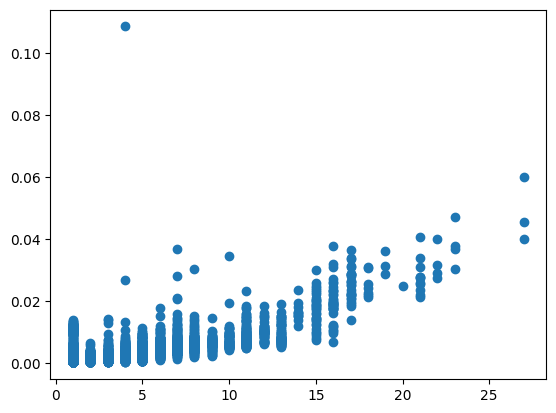

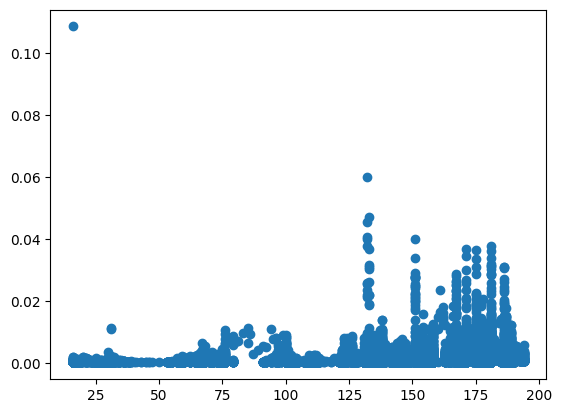

In [ ]:
plt.plot(n_configs_list, time_list, 'o')
plt.show()
plt.plot(n_cones_list, time_list, 'o')
# plt.ylim(0, 0.04)

In [ ]:
import rosbag

bag = rosbag.Bag('/mnt/c/Users/papal/Downloads/2022-10-12-14-55-06.bag')

In [ ]:
odoms = []
clusters = []

for topic, msg, t in bag.read_messages(topics=['/Odometry', "/slam/accumulated_clusters"]):
    if topic == "/Odometry":
        odoms.append(msg)
    elif topic == "/slam/accumulated_clusters":
        clusters.append(msg)

In [30]:
from fsd_path_planning.utils.math_utils import quaternion_to_euler_angles, unit_2d_vector_from_angle

def odometry_to_yaw(msg) -> None:

    position_xy = np.array(
        [
            msg.pose.pose.position.x,
            
            msg.pose.pose.position.y,
        ]
    )
    q = msg.pose.pose.orientation
    yaw = quaternion_to_euler_angles(np.array([q.x, q.y, q.z, q.w]))[2]

    direction_xy = unit_2d_vector_from_angle(yaw)

    return position_xy, direction_xy

In [ ]:
len(clusters), len(odoms)

(2036, 2042)

(-34.630396938323976,
 52.12814817428589,
 -48.876010274887086,
 17.84210810661316)

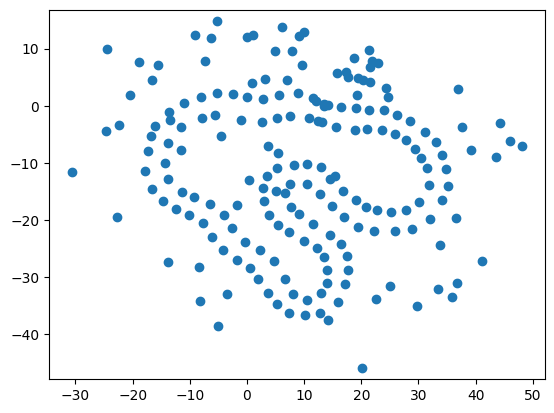

In [ ]:
from chabo_common.utils.parsing import pointcloud2_XYZI_to_array
from fsd_path_planning.utils.cone_types import ConeTypes

from sklearn.cluster import DBSCAN

def filter_clusters(clusters):
    return clusters
    model = DBSCAN(eps=2, min_samples=1).fit(clusters)

    out = []

    for l in set(model.labels_):
        mask = model.labels_ == l
        
        points_in_cluster = clusters[mask]

        if len(points_in_cluster) > 3:
            continue

        median = np.median(points_in_cluster, axis=0)

        out.append(median)

    return np.array(out)



def convert_pointscloud_to_cones_arrays(pc):
    array = pointcloud2_XYZI_to_array(pc)

    cones = [np.zeros((0,2)) for _ in ConeTypes]

    clusters = filter_clusters(array[:, :2])

    i = np.linalg.norm(clusters, axis=1).argsort()[1]
    mask_keep = np.ones(len(clusters), dtype=bool)
    mask_keep[i] = False

    clusters = clusters[mask_keep]

    cones[ConeTypes.UNKNOWN] = clusters

    return cones


x = convert_pointscloud_to_cones_arrays(clusters[-1])
plt.plot(*x[0].T, 'o')

# i = np.linalg.norm(x[0], axis=1).argsort()[1]
# print(i)
# plt.plot(*x[0][i], 'o', color='red')

plt.axis("equal")

In [ ]:
print(len(clusters), len(odoms))

2036 2042


In [ ]:

o = []

for odom, cluster in zip(odoms, clusters):
    cones = convert_pointscloud_to_cones_arrays(cluster)
    position, direction = odometry_to_yaw(odom)
    
    d = {
        "car_position": position.tolist(),
        "car_direction": direction.tolist(),
        "slam_cones": [x.tolist() for x in cones]
    }

    o.append(d)


    

In [ ]:
# idx_dist_change_start = 0

# for 

In [ ]:
import json
from pathlib import Path

Path('/home/papalotis/repos/fsd-path-planning/fsd_path_planning/demo/october_gatow_3.json').write_text(json.dumps(o[100:]))

12384599

In [11]:
import rosbag

bag = rosbag.Bag('/mnt/c/Users/papal/Downloads/layout_6_4_laps.bag')

In [13]:
cones_list = []
poses_list = []

for topic, msg, t in bag.read_messages(topics=['/slam/cones', "/slam/pose"]):
    if topic == "/slam/cones":
        cones_list.append(msg)
    elif topic == "/slam/pose":
        poses_list.append(msg)

print(len(cones_list), len(poses_list))

1749 1732


In [25]:
first_stamp = min(cones_list[0].header.stamp.to_sec(), poses_list[0].header.stamp.to_sec())

stamps_cones = np.array([x.header.stamp.to_sec() - first_stamp for x in cones_list])
stamps_poses = np.array([x.header.stamp.to_sec() - first_stamp for x in poses_list])

dist = np.abs(stamps_cones[:, None] - stamps_poses[None, :])

larger_dim = np.argmax(dist.shape)

idxs = np.argmin(dist, axis=larger_dim)

In [37]:
d = []

for i,pose in enumerate(poses_list):
    pose_x = pose.pose.position.x
    pose_y = pose.pose.position.y
    pose_xy = np.array([pose_x, pose_y])
    pose_yaw = quaternion_to_euler_angles(np.array([pose.pose.orientation.x, pose.pose.orientation.y, pose.pose.orientation.z, pose.pose.orientation.w]))[2]

    pose_dir = unit_2d_vector_from_angle(pose_yaw)

    c = cones_list[idxs[i]]
    carrays = []
    for cone_type in ConeTypes:
        cl = getattr(c.cone_observation, cone_type.name.lower())
        carrays.append(np.array([[oc.x, oc.y] for oc in cl]).reshape(-1, 2))

    dict_values = {
        "car_position": pose_xy.tolist(),
        "car_direction": pose_dir.tolist(),
        "slam_cones": [x.tolist() for x in carrays]
    }

    d.append(dict_values)



In [39]:
import json

# Path('/home/papalotis/repos/fsd-path-planning/fsd_path_planning/demo/layout_6_4_laps.json').write_text(json.dumps(d))

16132943

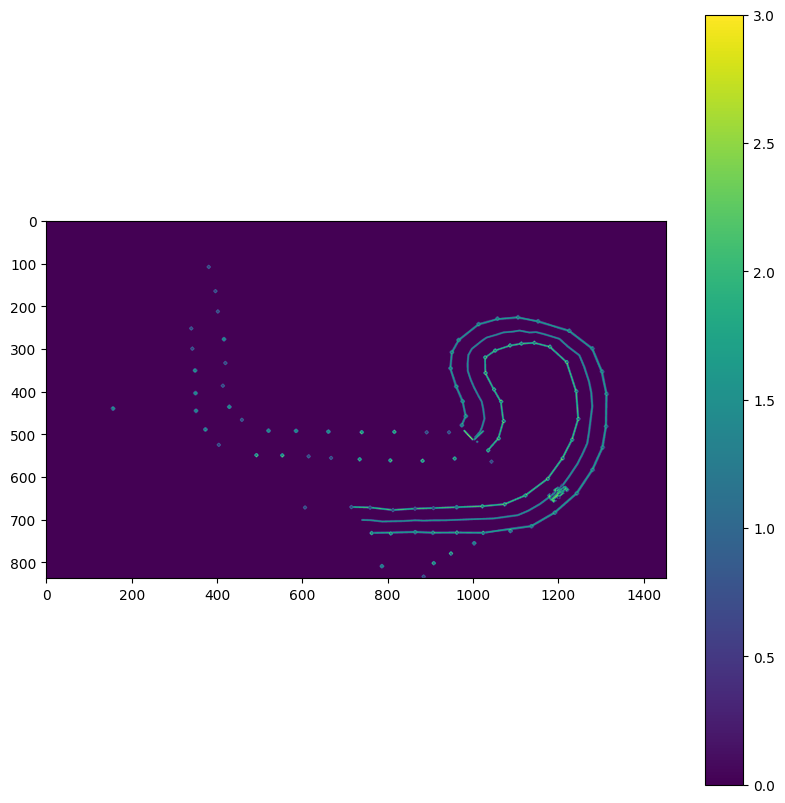

In [18]:
from skimage.io import imread
from skimage.color import rgb2hsv
import matplotlib.pyplot as plt

img = imread('/mnt/c/Users/papal/Downloads/frames_urinay/frame407.png')[:,:,:3]
img_hsv = rgb2hsv(img)

plt.figure(figsize=(10,10))
plt.imshow(img_hsv[:,:,2] * 3)
plt.colorbar()